In [2]:
!pip install numpy
!pip install matplotlib
!pip install scikit-image
!pip install pillow
!pip install opencv-python
# Check is at least python 3.9
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from PIL import Image
from typing import Callable
import os
from datetime import datetime
from enum import Enum
import random
from skimage.color import rgb2gray, rgb2hsv
from skimage import filters
from skimage import segmentation
from skimage.morphology import remove_small_holes, remove_small_objects
import cv2 as cv

In [4]:
class ImageType(Enum):
    NEUTRAL = "1. neutral_bg"
    NOISY = "2. noisy_bg"
    HAND = "3. hand"
    NEUTRAL_OOD = "4. neutral_bg_outliers"
    NOISY_OOD = "5. noisy_bg_outliers"
    HAND_OOD = "6. hand_outliers"
    
def loadImageOfType(type: ImageType, downsample: int = 1, grayscale: bool = False):
    # directory = f"./data/train/{type}"
    directory = os.path.join(".", "data", "train", type.value)
    images = os.listdir(directory)
    img = np.array(Image.open(os.path.join(directory, random.choice(images)))) 
    if downsample > 1:
        img = img[::downsample, ::downsample, :]
    if grayscale:
        img = (rgb2gray(img)*255).astype(np.uint8)
        
    # img = filters.sobel(img)
    
    return img
        


## Preprocessing

In [184]:
def filter_circles(circle_array):
    # print(circle_array)
    # Convert the array to a NumPy array
    
    # Find unique center coordinates
    unique_centers, unique_indices = np.unique(circle_array[:, :2], axis=0, return_index=True)
    # print(unique_indices)
    
    # Get the indices of circles with largest radius for each unique center
    largest_circles = []
    for center in unique_centers:
      largest_circle = np.array((center[0], center[1], 0))
      for j in range(len(circle_array)):
        circle = circle_array[j]
        if (circle[0] == center[0] and circle[1]==center[1] and circle[2] > largest_circle[2]):
          largest_circle[2] = circle[2] 
      largest_circles.append(largest_circle)
  
    # print(largest_circles)
               
      

    # # Convert the list of indices to a NumPy array
    # max_radius_indices = np.array(max_radius_indices)
    # print(max_radius_indices)
    
    return np.array(largest_circles)

detected 5 circles


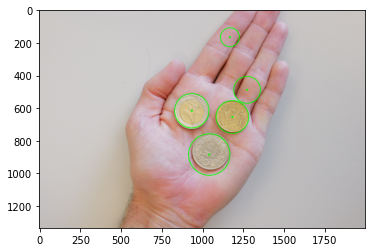

detected 4 circles


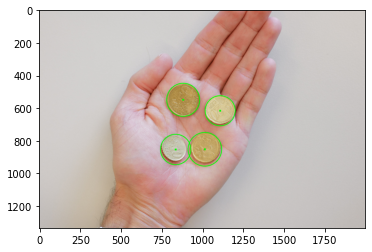

detected 5 circles


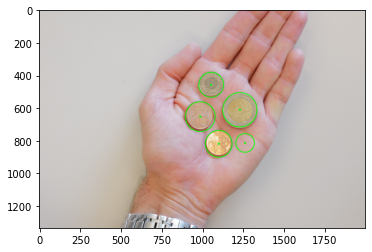

detected 6 circles


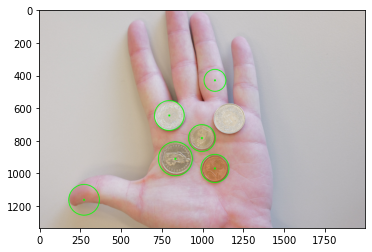

detected 1 circles


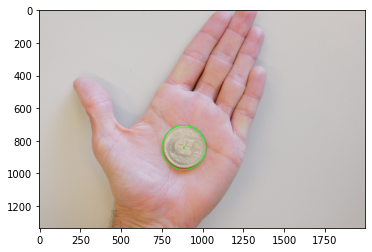

detected 6 circles


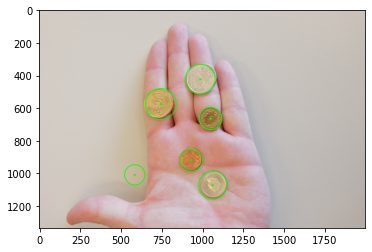

detected 4 circles


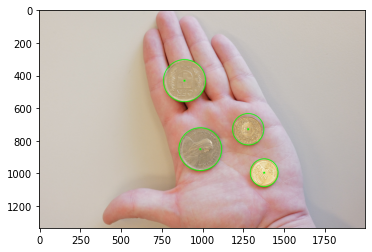

detected 6 circles


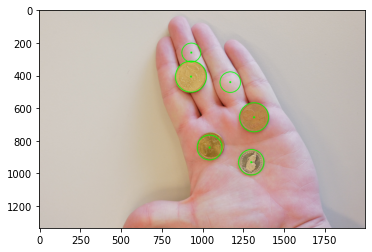

detected 4 circles


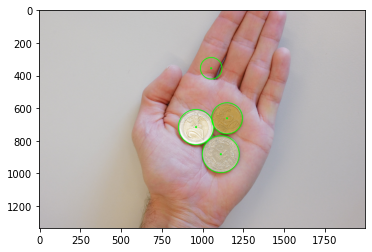

detected 4 circles


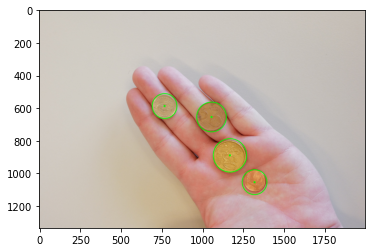

In [195]:
# d = "./data/train/1. neutral_bg//"
# d = "./data/train/2. noisy_bg///"
d = "./data/train/3. hand///"
# d = "./data/test//"
for f in os.listdir(d):

# img = cv.imread("./data/train/2. noisy_bg////L1010325.JPG")[::3, ::3].astype(np.uint8)
	img = cv.imread(f"{d}/{f}")[::3, ::3].astype(np.uint8)
	# img[:, :, 1] = 0

	output = img.copy()
	output[:, :, 0] = img[:, :, 2]
	output[:, :, 2] = img[:, :, 0]
	img[:, :, 2] = 0
	t = 160
	# mask = (img[:, :, 0] > t) & (img[:, :, 1] > t) &(img[:, :, 2] > t)

	# img[mask] = 0

	# plt.imshow(img)
	# plt.show()


	gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (8, 8))

	# canny = cv.Canny(gray, 100, 200)
	# plt.imshow(canny, cmap="gray")
	# plt.show()

	# detect circles in the image
	circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT_ALT, dp=1, minDist = 50, minRadius=50, maxRadius=200, param1=5, param2=0.6)
	# ensure at least some circles were found
	if circles is not None:
# convert the (x, y) coordinates and radius of the circles to integers
		circles = np.round(circles[0, :]).astype("int")
		circles = filter_circles(circles)
		print(f"detected {len(circles)} circles")
		# loop over the (x, y) coordinates and radius of the circles
		for (x, y, r) in circles:
			# print(x, y, r)
			# draw the circle in the output image, then draw a rectangle
				# corresponding to the center of the circle
			cv.circle(output, (x, y), r, (0, 255, 0), 4)
			cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 255, 0), -1)
		# show the output image
	plt.imshow(output)
	plt.show()

## Circle detection

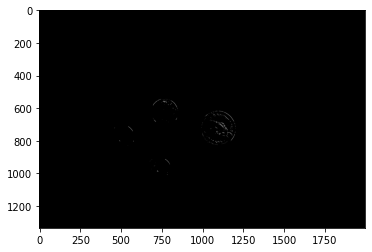

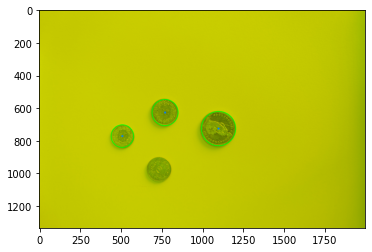

In [67]:
# Read image. 
d = "./data/train/1. neutral_bg//"
# d = "./data/train/2. noisy_bg///"
# d = "./data/train/3. hand///"
# d = "./data/test//"
# for f in os.listdir(d):
    # print(f)
# img = cv.imread(f"{d}/{f}")[::3, ::3].astype(np.uint8)

img = cv.imread("./data/train/1. neutral_bg///L1010279.JPG")[::3, ::3].astype(np.uint8)
# img = cv.imread("./data/train/2. noisy_bg//L1010370.JPG")[::3, ::3].astype(np.uint8)
# img = cv.imread("./data/train/3. hand//L1010395.JPG")[::3, ::3].astype(np.uint8)
img[:, :, 2] = 0
output = img.copy()
gray = cv.blur(cv.cvtColor(img, cv.COLOR_BGR2GRAY), (4, 4))

canny = cv.Canny(gray, 100, 100)
plt.imshow(canny, cmap="gray")
plt.show()

# detect circles in the image
circles = cv.HoughCircles(gray, cv.HOUGH_GRADIENT, dp=2, minDist = 50, minRadius=50, maxRadius=200, param1=100, param2=100)
# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv.circle(output, (x, y), r, (0, 255, 0), 4)
		cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
	# show the output image
plt.imshow(output)
plt.show()
	# exit()




## ORB test

In [ ]:
coins_dir = "./data/coins/"

def compute_descriptors(file, down=False, computed=False):

    if computed:
        img = file
    else:
        # img = cv.imread(file) # trainImage
        img = cv.imread(file, cv.IMREAD_GRAYSCALE) # trainImage
    if down:
        img = img[::2, ::2]
    # Initiate SIFT detector
    # sift = cv.SIFT_create()
    # # find the keypoints and descriptors with SIFT
    # kp, des = sift.detectAndCompute(img,None)

    orb = cv.ORB_create()
    # compute the descriptors with ORB
    kp, des = orb.detectAndCompute(img,None)

    return kp, des


def all_descriptors():
        

    descriptors = []
    keypoints = []

    for i, file in enumerate(os.listdir(coins_dir)):
        # print(file)
        kp, des = compute_descriptors(coins_dir+file)
        descriptors.append(des)
        keypoints.append(kp)

    return keypoints, descriptors

In [ ]:

coins_keypoints, coins_descriptors = all_descriptors()

In [ ]:
img = cv.imread("./data/train/2. noisy_bg//L1010325.JPG", cv.IMREAD_GRAYSCALE)

kpTest, desTest = compute_descriptors(img, False, True)

# bf = cv.BFMatcher()
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)
coins_match_imgs = []

all_matches = []
file_names = []
mean_dist = []

for i, file in enumerate(os.listdir(coins_dir)):
    file_names.append(file)
    coin_file = coins_dir+file
    img_coin = cv.imread(coin_file)
    kp_coin, des_coin = compute_descriptors(coin_file)
    # Match descriptors.
    matches = bf.match(des_coin,desTest)
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    all_matches.append(matches)
    
    distances = list(map(lambda x: x.distance, matches))
    mean_dist.append(np.mean(distances))
    
    
    img3 = cv.drawMatches(img_coin, kp_coin,img,kpTest,matches,None, matchesThickness=2, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    coins_match_imgs.append(img3)

    # print(matches)



# print(len(coins_match_imgs))


In [ ]:
fig, axs = plt.subplots(8, 3)
fig.set_size_inches(20,30)
for i in range(len(coins_match_imgs)):
    x = i // 3
    y = i % 3
    axs[x, y].imshow(coins_match_imgs[i])
    axs[x, y].axis(False)
    axs[x, y].set_title(f"{file_names[i]} - {all_matches[i][0].distance}")
    

In [ ]:
plt.imshow(coins_match_imgs[0])
print(all_matches[20][0].distance)
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(10, 8)

for i, type in enumerate(ImageType):
    x = i// 3
    y = i%3
    axs[x, y].imshow(loadImageOfType(type, downsample= 2))
    # axs[x, y].axis(False)
    axs[x, y].set_title(type.name)
fig.tight_layout()
plt.show()

## HSV test

In [ ]:
rgb_img = loadImageOfType(ImageType.HAND, downsample=4)
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(15,10))

z1 = ax0.imshow(rgb_img[:, :, 0], cmap="gray")
ax0.set_title("R channel")
ax0.axis('off')
ax1.imshow(rgb_img[:, :, 1], cmap="gray")
ax1.set_title("G channel")
ax1.axis('off')
ax2.imshow(rgb_img[:, :, 2], cmap="gray")
ax2.set_title("B channel")
ax2.axis('off')
ax3.imshow(filters.sobel(rgb_img[:, :, 2]), cmap="gray")
ax3.set_title("B channel")
ax3.axis('off')
# ax2.colorbar()
# plt.colorbar(z1,cax=ax0)

fig.tight_layout()

# Segmentation

In [ ]:
def extract_rgb_channels(img):
    data_red = img[:,:,0]
    data_green = img[:,:,1]
    data_blue = img[:,:,2]
    
    return data_red, data_green, data_blue

# Plot color space distribution 
def plot_colors_histo(
    img: np.ndarray,
    func: Callable,
    labels: list[str],
):

    # Extract colors
    channels = func(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()



In [ ]:
t_red = 195
t_green = 195
t_blue = 190

def apply_rgb_threshold(img):
    r_mask = img[:, :, 0] > t_red 
    g_mask = img[:, :, 1] < t_green
    b_mask = img[:, :, 2] < t_blue
    
    return r_mask & g_mask & b_mask
## Best result obtained using the red_threshold channel

### Ploting RGB channels

In [ ]:
def plotRGBchannels(img):
    
## Add histograms of RGB channels to get a better visualization for chosing the Threshold Values

    nb_bins = 256

    # Display histogram
    fig, axs = plt.subplots(3, 1, figsize=(8, 10))

    # Red channel histogram
    axs[0].hist(img[:, :, 0].ravel(), bins=nb_bins, color='red', alpha=0.7)
    axs[0].set_xlabel('Pixel intensity')
    axs[0].set_ylabel('Number of pixels')
    axs[0].set_title('Red Channel Histogram')
    axs[0].set_xticks(np.arange(0, 256, 10)) 
    axs[0].axvline(t_red, color="black")


    # Green channel histogram
    axs[1].hist(img[:, :, 1].ravel(), bins=nb_bins, color='green', alpha=0.7)
    axs[1].set_xlabel('Pixel intensity')
    axs[1].set_ylabel('Number of pixels')
    axs[1].set_title('Green Channel Histogram')
    axs[1].set_xticks(np.arange(0, 256, 10))
    axs[1].axvline(t_green, color="black")


    # Blue channel histogram
    axs[2].hist(img[:, :, 2].ravel(), bins=nb_bins, color='blue', alpha=0.7)
    axs[2].set_xlabel('Pixel intensity')
    axs[2].set_ylabel('Number of pixels')
    axs[2].set_title('Blue Channel Histogram')
    axs[2].set_xticks(np.arange(0, 256, 10)) 
    axs[2].axvline(t_blue, color="black")



    plt.tight_layout()
    plt.show()

### test rgb thresholding

In [ ]:

img = loadImageOfType(type=ImageType.NOISY, downsample=3)
plt.imshow(img)
plt.show()
plotRGBchannels(img)

In [ ]:
img = loadImageOfType(type=ImageType.HAND, downsample=3)
plt.imshow(img)
plt.show()
t_img = np.array(img)


t_img = apply_rgb_threshold(img).astype(bool)
t_img = remove_small_holes(t_img, 200)
plt.imshow(t_img, cmap="gray")

plt.show()
plotRGBchannels(img)

In [ ]:
from skimage.morphology import closing,opening, disk


def apply_closing(img_th, disk_size):
    img_closing = np.zeros_like(img_th)

    selem = disk(disk_size)
    img_closing = closing(img_th, selem)

    return img_closing


def apply_opening(img_th, disk_size):
    selem = disk(disk_size)
    img_opening = opening(img_th, selem)
    return img_opening



def plot_images(
    imgs: np.ndarray,
    sizes: list[int],
    title: str,
):
    D = len(imgs)
    nrows = 2 if D <= 4 else int(np.ceil(D / 3))
    ncols = int(np.ceil(D / nrows))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5* nrows))
    
    # Remove axis
    axes = axes.ravel()
    [ax.axis('off') for ax in axes]

    for i in range(nrows * ncols):
        if i < D:
            axes[i].imshow(imgs[i])
            axes[i].set_title(f"Size: {sizes[i]}")

    plt.suptitle(title)

    # Adjust layout
    # pad=0.4 increases spacing to reduce text overlap, w_pad/h_pad can adjust spacing between subplots
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    plt.show() 

In [ ]:
disk_sizes = [1, 2, 5, 10]
imgs_closing = []
imgs_opening = []
# Apply threhsold in HSV space
img = loadImageOfType(ImageType.NEUTRAL, downsample=4)
print(img.shape)
plt.imshow(img)
plt.show()
# apply_closing(img[:, :, 0], 10)


# Apply opening and closing to masked image 
for d in disk_sizes:
    pass
    # imgs_closing.append(apply_closing(img, d))
    # imgs_opening.append(apply_opening(img, d))
    
# Plot results
# plot_images(imgs=imgs_closing, sizes=disk_sizes, title="Closing")
# plot_images(imgs=imgs_opening, sizes=disk_sizes, title="Opening")

In [ ]:
from skimage.exposure import histogram
def plotHistogram(img):
    hist, hist_centers = histogram(img)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    axes[0].imshow(img, cmap=plt.cm.gray)
    axes[0].set_axis_off()
    axes[1].plot(hist_centers, hist, lw=2)
    axes[1].set_title('histogram of gray values')

In [ ]:

img = loadImageOfType(ImageType.NOISY, downsample=8, grayscale=True)


# plotHistogram(img)

elevation_map = filters.sobel(img)
markers = np.zeros_like(img)
markers[img < 170] = 2
markers[img > 200] = 1
segmentation_coins = (segmentation.watershed(elevation_map, markers) - 1).astype(bool)
segmentation_coins = remove_small_holes(segmentation_coins, 300)



fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 10)
axs[0].imshow(img, cmap="gray")
axs[1].imshow(segmentation_coins, cmap="gray")
plt.show()